# Multi-Agent Lunar Lander Projekt

## (DHBW Mannheim - Kurs Aktuelle Data Science Entwicklungen - Reinforcement Learning)

Dieses Jupyter Notebook dient als interaktive Demonstration und zentraler Ausführungspunkt für das Projekt. Es kombiniert die Funktionalitäten der Skripte `train.py`, `test.py` und `evaluate.py` in einem einzigen, nachvollziehbaren Workflow.

### Projektübersicht

Das Ziel dieses Projekts ist die Erforschung und der Vergleich verschiedener intelligenter Agenten zur Lösung der anspruchsvollen "LunarLander-v3"-Umgebung. In dieser Simulationsumgebung muss ein Agent lernen, ein Raumschiff sanft und präzise auf einer vorgegebenen Landeplattform zu landen. 

Wir werden ein breites Spektrum an Agenten-Architekturen trainieren und vergleichen:
*   Einen **Zufallsagenten** als Baseline.
*   Fortschrittliche **Reinforcement Learning (RL)** Algorithmen: **DQN**, **REINFORCE**, **A2C** und **PPO**.
*   **Evolutionäre Algorithmen:** **Genetischer Algorithmus (GA)** und **Evolutionäre Strategien (ES)**.

Das Notebook ist in vier Hauptteile gegliedert:
1.  **Setup & Konfiguration:** Laden der Bibliotheken und Festlegen aller wichtigen Parameter.
2.  **Training der Agenten:** Jeder Agent wird trainiert, und sein Lernfortschritt wird visualisiert.
3.  **Qualitative Evaluierung:** Visueller Test eines einzelnen Agenten mit GIF-Erstellung.
4.  **Quantitative Evaluierung:** Systematischer Leistungsvergleich aller Agenten mit Tabellen und Diagrammen.

## 1. Setup & Konfiguration

Zuerst importieren wir alle notwendigen Bibliotheken und legen die globalen Konfigurationen fest. Anstatt eine `config.py`-Datei zu verwenden, definieren wir alle Parameter direkt hier im Notebook. Dies erhöht die Transparenz und erleichtert das Experimentieren.

In [2]:
# === Grundlegende Importe ===
import gymnasium as gym
import numpy as np
import torch
import random
import os
import csv
from collections import deque
import time

# === Importe für Visualisierung ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from IPython.display import Image, display

# === Agenten-Importe aus dem 'agents' Verzeichnis ===
from agents import (
    AGENT_REGISTRY, DQNAgent, GeneticAlgorithmController, GeneticAgent,
    REINFORCEAgent, A2CAgent, PPOAgent, ESAgent
)
from agents.genetic_agent import PolicyNetwork as GAPolicyNetwork

# Matplotlib-Stil für ansprechendere Plots setzen
plt.style.use('seaborn-v0_8-whitegrid')

### Globale Konfigurationen

Hier sind alle Hyperparameter und Einstellungen zentralisiert. Passen Sie diese Werte an, um das Verhalten der Trainings- und Evaluierungsprozesse zu ändern.

In [3]:
# === Globale Konfigurationen ===
ENV_ID = "LunarLander-v3"
SEED = 42
AGENT_TYPES = ["random", "dqn", "reinforce", "a2c", "ppo", "genetic", "es"] # Reihenfolge für Evaluierung

# Pfade
PROJECT_ROOT = os.getcwd()
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")
GIF_DIR = os.path.join(PROJECT_ROOT, "gifs")
DQN_MODEL_PATH = os.path.join(MODEL_DIR, "dqn_lunar_lander.pth")
GA_MODEL_PATH = os.path.join(MODEL_DIR, "ga_best_lunar_lander.pth")
REINFORCE_MODEL_PATH = os.path.join(MODEL_DIR, "reinforce_lunar_lander.pth")
A2C_MODEL_PATH = os.path.join(MODEL_DIR, "a2c_lunar_lander.pth")
PPO_ACTOR_MODEL_PATH = os.path.join(MODEL_DIR, "ppo_actor_lunar_lander.pth")
PPO_CRITIC_MODEL_PATH = os.path.join(MODEL_DIR, "ppo_critic_lunar_lander.pth")
ES_MODEL_PATH = os.path.join(MODEL_DIR, "es_lunar_lander.pth")
EVALUATION_CSV_PATH = os.path.join(MODEL_DIR, "evaluation_summary.csv")

# === Flags zum Erzwingen von Neutraining ===
FORCE_RETRAIN_ALL = False # Überschreibt alle individuellen Flags
FORCE_RETRAIN_DQN = FORCE_RETRAIN_ALL or False
FORCE_RETRAIN_GA = FORCE_RETRAIN_ALL or False
FORCE_RETRAIN_REINFORCE = FORCE_RETRAIN_ALL or False
FORCE_RETRAIN_A2C = FORCE_RETRAIN_ALL or False
FORCE_RETRAIN_PPO = FORCE_RETRAIN_ALL or False
FORCE_RETRAIN_ES = FORCE_RETRAIN_ALL or False

# === Trainingsparameter ===
DQN_TRAIN_EPISODES = 2000
DQN_MAX_T_PER_EPISODE = 1000
DQN_SCORE_TARGET = 200.0
DQN_PRINT_EVERY = 100

REINFORCE_TRAIN_EPISODES = 3000
REINFORCE_MAX_T_PER_EPISODE = 1000
REINFORCE_SCORE_TARGET = 200.0
REINFORCE_PRINT_EVERY = 100

A2C_TRAIN_EPISODES = 2500
A2C_MAX_T_PER_EPISODE = 1000
A2C_SCORE_TARGET = 200.0
A2C_PRINT_EVERY = 100

PPO_TOTAL_TIMESTEPS = 200000
PPO_UPDATE_HORIZON = 2048 
PPO_SCORE_TARGET = 230.0
PPO_PRINT_EVERY_N_UPDATES = 10

GA_N_GENERATIONS = 100
GA_EVAL_EPISODES_PER_INDIVIDUAL = 3
GA_MAX_STEPS_PER_GA_EVAL = 500
GA_SAVE_EVERY_N_GENERATIONS = 10

ES_N_GENERATIONS = 200
ES_EVAL_EPISODES_PER_PARAM = 2
ES_SCORE_TARGET = 200.0
ES_PRINT_EVERY = 10

# === Evaluierungsparameter ===
NUM_EVAL_EPISODES = 100 # Reduziert für schnelle Notebook-Ausführung, für finale Ergebnisse auf 1000 erhöhen
MAX_STEPS_PER_EVAL_EPISODE = 1000

# === Test-Parameter (für qualitative Analyse/GIFs) ===
NUM_TEST_RUNS = 10 
NUM_RUNS_FOR_GIF = 3 # Anzahl der Durchläufe, die in einem GIF kombiniert werden

# === Hardware-Konfiguration ===
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Verwende Gerät: {DEVICE}")

Verwende Gerät: cuda:0


### Hilfsfunktionen

Diese Funktionen kümmern sich um die grundlegende Einrichtung, wie das Setzen von Seeds für die Reproduzierbarkeit und das Erstellen der notwendigen Verzeichnisse.

In [4]:
def ensure_model_dir_exists():
    """Stellt sicher, dass das `models` und `gifs` Verzeichnis existiert."""
    for path in [MODEL_DIR, GIF_DIR]:
        if not os.path.exists(path):
            try:
                os.makedirs(path)
                print(f"Verzeichnis erstellt: {path}")
            except OSError as e:
                print(f"Fehler beim Erstellen des Verzeichnisses {path}: {e}")

def setup_seeds(seed_value):
    """Setzt Zufallsgeneratoren-Seeds für Reproduzierbarkeit."""
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    print(f"Seeds gesetzt auf: {seed_value}")

# Einmalige Ausführung der Setup-Funktionen
ensure_model_dir_exists()
setup_seeds(SEED)

# Temporäre Umgebung erstellen, um Dimensionen zu erhalten
temp_env = gym.make(ENV_ID)
observation_space = temp_env.observation_space
action_space = temp_env.action_space
temp_env.close()

Seeds gesetzt auf: 42


## 2. Training der Agenten

In diesem Abschnitt trainieren wir die verschiedenen lernfähigen Agenten. Für jeden Agenten wird eine spezifische Trainingsfunktion aufgerufen. Die Logik prüft zuerst, ob bereits ein trainiertes Modell existiert und ob ein Neutraining erzwungen wird. 

**Das Besondere hier im Notebook:** Nach jedem Trainingsprozess visualisieren wir den Lernfortschritt direkt mit einem Plot, um die Leistung über die Zeit zu sehen.

### 2.1 Deep Q-Network (DQN) Agent

In [5]:
def train_dqn_agent(obs_space, act_space):
    print("\n--- Training DQN Agent ---")
    dqn_agent = DQNAgent(obs_space, act_space, seed=SEED)
    scores_deque = deque(maxlen=100)
    scores_history = []
    avg_scores_history = []
    train_env = gym.make(ENV_ID)
    
    print(f"Starte DQN Training für {DQN_TRAIN_EPISODES} Episoden...")
    start_time = time.time()

    for i_episode in range(1, DQN_TRAIN_EPISODES + 1):
        obs, _ = train_env.reset(seed=SEED + i_episode)
        score = 0
        dqn_agent.reset()

        for t in range(DQN_MAX_T_PER_EPISODE):
            action = dqn_agent.select_action(obs)
            next_obs, reward, terminated, truncated, _ = train_env.step(action)
            dqn_agent.learn(obs, action, reward, next_obs, terminated, truncated)
            obs = next_obs
            score += reward
            if terminated or truncated: break
        
        scores_deque.append(score)
        scores_history.append(score)
        avg_score = np.mean(scores_deque)
        avg_scores_history.append(avg_score)

        if i_episode % DQN_PRINT_EVERY == 0 or i_episode == DQN_TRAIN_EPISODES:
            print(f'\rEpisode {i_episode}/{DQN_TRAIN_EPISODES}\tAvg Score (letzte 100): {avg_score:.2f}\tEpsilon: {dqn_agent.epsilon:.4f}')
        
        if len(scores_deque) >= 100 and avg_score >= DQN_SCORE_TARGET:
            print(f'\nUmgebung in {i_episode-100:d} Episoden gelöst! Avg Score: {avg_score:.2f}')
            break
            
    train_env.close()
    end_time = time.time()
    print(f"DQN Training beendet nach {end_time - start_time:.2f} Sekunden. Speichere Modell...")
    dqn_agent.save(DQN_MODEL_PATH)
    return scores_history, avg_scores_history

if FORCE_RETRAIN_DQN or not os.path.exists(DQN_MODEL_PATH):
    dqn_scores, dqn_avg_scores = train_dqn_agent(observation_space, action_space)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(dqn_scores)), dqn_scores, label='Score pro Episode', alpha=0.6)
    plt.plot(np.arange(len(dqn_avg_scores)), dqn_avg_scores, label='Gleitender Durchschnitt (100 Episoden)', color='red', linewidth=2)
    plt.axhline(y=DQN_SCORE_TARGET, color='g', linestyle='--', label=f'Ziel ({DQN_SCORE_TARGET} Punkte)')
    plt.title('DQN Trainingsfortschritt')
    plt.xlabel('Episode')
    plt.ylabel('Gesamtbelohnung')
    plt.legend()
    plt.show()
else:
    print("DQN-Modell existiert bereits. Training übersprungen.")

DQN-Modell existiert bereits. Training übersprungen.


### 2.2 REINFORCE Agent

In [6]:
def train_reinforce_agent(obs_space, act_space):
    print("\n--- Training REINFORCE Agent ---")
    agent = REINFORCEAgent(
        obs_space, act_space, seed=SEED, learning_rate=0.001 # Beispiel-LR
    )
    scores_deque = deque(maxlen=100)
    scores_history = []
    avg_scores_history = []
    train_env = gym.make(ENV_ID)
    
    print(f"Starte REINFORCE Training für {REINFORCE_TRAIN_EPISODES} Episoden...")
    start_time = time.time()
    
    for i_episode in range(1, REINFORCE_TRAIN_EPISODES + 1):
        obs, _ = train_env.reset(seed=SEED + i_episode)
        agent.reset()
        score = 0
        for t in range(REINFORCE_MAX_T_PER_EPISODE):
            action = agent.select_action(obs)
            next_obs, reward, terminated, truncated, _ = train_env.step(action)
            agent.store_reward(reward)
            obs = next_obs
            score += reward
            if terminated or truncated: break
        
        agent.learn_episode()
        scores_deque.append(score)
        scores_history.append(score)
        avg_score = np.mean(scores_deque)
        avg_scores_history.append(avg_score)

        if i_episode % REINFORCE_PRINT_EVERY == 0 or i_episode == REINFORCE_TRAIN_EPISODES:
            print(f'\rEpisode {i_episode}/{REINFORCE_TRAIN_EPISODES}\tAvg Score (letzte 100): {avg_score:.2f}')
        
        if len(scores_deque) >= 100 and avg_score >= REINFORCE_SCORE_TARGET:
            print(f'\nUmgebung gelöst in {i_episode-100:d} Episoden! Avg Score: {avg_score:.2f}')
            break
            
    train_env.close()
    end_time = time.time()
    print(f"REINFORCE Training beendet nach {end_time - start_time:.2f} Sekunden. Speichere Modell...")
    agent.save(REINFORCE_MODEL_PATH)
    return scores_history, avg_scores_history

if FORCE_RETRAIN_REINFORCE or not os.path.exists(REINFORCE_MODEL_PATH):
    reinforce_scores, reinforce_avg_scores = train_reinforce_agent(observation_space, action_space)
    
    plt.figure(figsize=(12, 6))
    plt.plot(reinforce_scores, label='Score pro Episode', alpha=0.6)
    plt.plot(reinforce_avg_scores, label='Gleitender Durchschnitt (100 Episoden)', color='red', linewidth=2)
    plt.axhline(y=REINFORCE_SCORE_TARGET, color='g', linestyle='--', label=f'Ziel ({REINFORCE_SCORE_TARGET} Punkte)')
    plt.title('REINFORCE Trainingsfortschritt')
    plt.xlabel('Episode')
    plt.ylabel('Gesamtbelohnung')
    plt.legend()
    plt.show()
else:
    print("REINFORCE-Modell existiert bereits. Training übersprungen.")

REINFORCE-Modell existiert bereits. Training übersprungen.


### 2.3 Advantage Actor-Critic (A2C) Agent

In [7]:
def train_a2c_agent(obs_space, act_space):
    print("\n--- Training A2C Agent ---")
    agent = A2CAgent(obs_space, act_space, seed=SEED)
    scores_deque = deque(maxlen=100)
    scores_history = []
    avg_scores_history = []
    train_env = gym.make(ENV_ID)
    
    print(f"Starte A2C Training für {A2C_TRAIN_EPISODES} Episoden...")
    start_time = time.time()
    
    for i_episode in range(1, A2C_TRAIN_EPISODES + 1):
        obs, _ = train_env.reset(seed=SEED + i_episode)
        score = 0
        for t in range(A2C_MAX_T_PER_EPISODE):
            action = agent.select_action(obs)
            next_obs, reward, terminated, truncated, _ = train_env.step(action)
            agent.learn(obs, action, reward, next_obs, terminated, truncated)
            obs = next_obs
            score += reward
            if terminated or truncated: break
        
        scores_deque.append(score)
        scores_history.append(score)
        avg_score = np.mean(scores_deque)
        avg_scores_history.append(avg_score)
        
        if i_episode % A2C_PRINT_EVERY == 0 or i_episode == A2C_TRAIN_EPISODES:
            print(f'\rEpisode {i_episode}/{A2C_TRAIN_EPISODES}\tAvg Score (letzte 100): {avg_score:.2f}')
            
        if len(scores_deque) >= 100 and avg_score >= A2C_SCORE_TARGET:
            print(f'\nUmgebung gelöst in {i_episode-100:d} Episoden! Avg Score: {avg_score:.2f}')
            break

    train_env.close()
    end_time = time.time()
    print(f"A2C Training beendet nach {end_time - start_time:.2f} Sekunden. Speichere Modell...")
    agent.save(A2C_MODEL_PATH)
    return scores_history, avg_scores_history

if FORCE_RETRAIN_A2C or not os.path.exists(A2C_MODEL_PATH):
    a2c_scores, a2c_avg_scores = train_a2c_agent(observation_space, action_space)
    
    plt.figure(figsize=(12, 6))
    plt.plot(a2c_scores, label='Score pro Episode', alpha=0.6)
    plt.plot(a2c_avg_scores, label='Gleitender Durchschnitt (100 Episoden)', color='red', linewidth=2)
    plt.axhline(y=A2C_SCORE_TARGET, color='g', linestyle='--', label=f'Ziel ({A2C_SCORE_TARGET} Punkte)')
    plt.title('A2C Trainingsfortschritt')
    plt.xlabel('Episode')
    plt.ylabel('Gesamtbelohnung')
    plt.legend()
    plt.show()
else:
    print("A2C-Modell existiert bereits. Training übersprungen.")

A2C-Modell existiert bereits. Training übersprungen.


### 2.4 Proximal Policy Optimization (PPO) Agent

In [8]:
def train_ppo_agent(obs_space, act_space):
    print("\n--- Training PPO Agent ---")
    agent = PPOAgent(obs_space, act_space, seed=SEED, update_horizon=PPO_UPDATE_HORIZON)
    train_env = gym.make(ENV_ID)

    print(f"Starte PPO Training für ca. {PPO_TOTAL_TIMESTEPS} Zeitschritte...")
    start_time = time.time()
    
    obs, _ = train_env.reset(seed=SEED)
    current_episode_reward = 0
    completed_episodes = 0
    scores_deque = deque(maxlen=100)
    updates_done = 0
    
    # Für Plotting
    timesteps_history = []
    avg_scores_history = []

    for timestep in range(1, PPO_TOTAL_TIMESTEPS + 1):
        action = agent.select_action(obs, store_in_memory=True)
        next_obs, reward, terminated, truncated, _ = train_env.step(action)
        agent.store_transition_result(reward, terminated or truncated)
        obs = next_obs
        current_episode_reward += reward

        if terminated or truncated:
            scores_deque.append(current_episode_reward)
            completed_episodes += 1
            obs, _ = train_env.reset(seed=SEED + completed_episodes)
            current_episode_reward = 0

        if len(agent.memory_actions) >= PPO_UPDATE_HORIZON:
            last_obs_for_value_est = obs if not (terminated or truncated) else None
            agent.learn_from_memory(last_obs_for_value_est)
            updates_done += 1

            if updates_done % PPO_PRINT_EVERY_N_UPDATES == 0 and scores_deque:
                avg_score = np.mean(scores_deque)
                timesteps_history.append(timestep)
                avg_scores_history.append(avg_score)
                print(f"Zeitschritt: {timestep}/{PPO_TOTAL_TIMESTEPS} | Avg Reward (letzte 100 Eps): {avg_score:.2f}")
                agent.save(PPO_ACTOR_MODEL_PATH, PPO_CRITIC_MODEL_PATH)

            if scores_deque and np.mean(scores_deque) >= PPO_SCORE_TARGET and len(scores_deque) >= 100:
                print(f"\nUmgebung mit PPO gelöst! Avg Score: {np.mean(scores_deque):.2f}")
                break
    
    train_env.close()
    end_time = time.time()
    print(f"PPO Training beendet nach {end_time - start_time:.2f} Sekunden. Speichere finales Modell...")
    agent.save(PPO_ACTOR_MODEL_PATH, PPO_CRITIC_MODEL_PATH)
    return timesteps_history, avg_scores_history

if FORCE_RETRAIN_PPO or not (os.path.exists(PPO_ACTOR_MODEL_PATH) and os.path.exists(PPO_CRITIC_MODEL_PATH)):
    ppo_timesteps, ppo_avg_scores = train_ppo_agent(observation_space, action_space)
    
    if ppo_timesteps:
        plt.figure(figsize=(12, 6))
        plt.plot(ppo_timesteps, ppo_avg_scores, label='Gleitender Durchschnitt (100 Episoden)', marker='.')
        plt.axhline(y=PPO_SCORE_TARGET, color='g', linestyle='--', label=f'Ziel ({PPO_SCORE_TARGET} Punkte)')
        plt.title('PPO Trainingsfortschritt')
        plt.xlabel('Trainings-Zeitschritte')
        plt.ylabel('Durchschnittliche Belohnung')
        plt.legend()
        plt.show()
else:
    print("PPO-Modelle existieren bereits. Training übersprungen.")

PPO-Modelle existieren bereits. Training übersprungen.


### 2.5 Genetischer Algorithmus (GA) Agent

In [9]:
def train_ga_agent(obs_space, act_space):
    print("\n--- Training Genetischer Algorithmus Agent ---")
    ga_controller = GeneticAlgorithmController(
        state_size=obs_space.shape[0],
        action_size=act_space.n,
        env_id=ENV_ID,
        n_generations=GA_N_GENERATIONS,
        seed=SEED
    )
    
    fitness_history = {"mean": [], "max": [], "best_overall": []}
    
    print(f"Starte GA Training für {GA_N_GENERATIONS} Generationen...")
    start_time = time.time()
    
    for gen in range(GA_N_GENERATIONS):
        mean_fitness, max_fitness = ga_controller.evolve_population()
        print(f"Generation {gen + 1}/{GA_N_GENERATIONS} - Mean Fitness: {mean_fitness:.2f}, Max Fitness: {max_fitness:.2f}, Best Overall: {ga_controller.best_fitness:.2f}")
        
        fitness_history["mean"].append(mean_fitness)
        fitness_history["max"].append(max_fitness)
        fitness_history["best_overall"].append(ga_controller.best_fitness)
        
        if (gen + 1) % GA_SAVE_EVERY_N_GENERATIONS == 0 or (gen + 1) == GA_N_GENERATIONS:
            ga_controller.save_best_individual(GA_MODEL_PATH)

    end_time = time.time()
    print(f"GA Training beendet nach {end_time - start_time:.2f} Sekunden. Beste Policy gespeichert.")
    return fitness_history

if FORCE_RETRAIN_GA or not os.path.exists(GA_MODEL_PATH):
    ga_fitness = train_ga_agent(observation_space, action_space)
    
    plt.figure(figsize=(12, 6))
    plt.plot(ga_fitness['mean'], label='Durchschnittliche Fitness der Generation', alpha=0.7)
    plt.plot(ga_fitness['max'], label='Maximale Fitness der Generation', alpha=0.7)
    plt.plot(ga_fitness['best_overall'], label='Beste gefundene Fitness (insgesamt)', color='red', linewidth=2)
    plt.title('GA Trainingsfortschritt (Fitness über Generationen)')
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Durchschnittliche Belohnung)')
    plt.legend()
    plt.show()
else:
    print("GA-Modell existiert bereits. Training übersprungen.")

GA-Modell existiert bereits. Training übersprungen.


### 2.6 Evolutionäre Strategien (ES) Agent

In [10]:
def train_es_agent(obs_space, act_space):
    print("\n--- Training Evolutionäre Strategien (ES) Agent ---")
    es_controller = ESAgent(obs_space, act_space, seed=SEED)
    eval_env_for_es = gym.make(ENV_ID)
    
    fitness_history = {"central": [], "best_overall": []}
    
    print(f"Starte ES Training für {ES_N_GENERATIONS} Generationen...")
    start_time = time.time()

    for gen in range(1, ES_N_GENERATIONS + 1):
        mean_pop_fitness, max_pop_fitness, central_fitness = es_controller.evolve_step(eval_env_for_es)
        fitness_history["central"].append(central_fitness)
        fitness_history["best_overall"].append(es_controller.current_best_fitness)

        if gen % ES_PRINT_EVERY == 0 or gen == ES_N_GENERATIONS:
            print(f"ES Gen {gen}/{ES_N_GENERATIONS} | Central Fit: {central_fitness:.2f} | Best Overall: {es_controller.current_best_fitness:.2f}")
            es_controller.save(ES_MODEL_PATH)

        if es_controller.current_best_fitness >= ES_SCORE_TARGET:
            print(f"\nES Ziel-Score erreicht! Beste Fitness: {es_controller.current_best_fitness:.2f}")
            break
            
    eval_env_for_es.close()
    end_time = time.time()
    print(f"ES Training beendet nach {end_time - start_time:.2f} Sekunden. Speichere finales bestes Modell...")
    es_controller.save(ES_MODEL_PATH)
    return fitness_history

if FORCE_RETRAIN_ES or not os.path.exists(ES_MODEL_PATH):
    es_fitness = train_es_agent(observation_space, action_space)
    
    plt.figure(figsize=(12, 6))
    plt.plot(es_fitness['central'], label='Fitness der zentralen Policy', alpha=0.7)
    plt.plot(es_fitness['best_overall'], label='Beste gefundene Fitness (insgesamt)', color='red', linewidth=2)
    plt.axhline(y=ES_SCORE_TARGET, color='g', linestyle='--', label=f'Ziel ({ES_SCORE_TARGET} Punkte)')
    plt.title('ES Trainingsfortschritt (Fitness über Generationen)')
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Durchschnittliche Belohnung)')
    plt.legend()
    plt.show()
else:
    print("ES-Modell existiert bereits. Training übersprungen.")

ES-Modell existiert bereits. Training übersprungen.


## 3. Qualitative Evaluierung (Visueller Test)

Nachdem die Modelle trainiert sind, wollen wir das Verhalten eines ausgewählten Agenten visuell inspizieren. Der folgende Code lädt einen Agenten, führt mehrere Testläufe durch und erstellt ein animiertes GIF, das direkt im Notebook angezeigt wird. 

**Ändern Sie die Variable `agent_type_to_test`, um verschiedene Agenten zu testen.**

PPO Agent initialisiert. Gerät: cuda:0
PPO Actor geladen von /home/german/Coding/lunar_lander_reinforcement_genetic_policy_learning/models/ppo_actor_lunar_lander.pth
PPO Critic geladen von /home/german/Coding/lunar_lander_reinforcement_genetic_policy_learning/models/ppo_critic_lunar_lander.pth
Agent 'PPO' erfolgreich für den Test geladen.

Starte 10 Testläufe für Agent 'PPO'...
  Lauf 1/10: Belohnung = 315.15
  Lauf 2/10: Belohnung = 267.20
  Lauf 3/10: Belohnung = 253.19
  Lauf 4/10: Belohnung = 317.13
  Lauf 5/10: Belohnung = 279.45
  Lauf 6/10: Belohnung = 306.73
  Lauf 7/10: Belohnung = 306.01
  Lauf 8/10: Belohnung = 286.65
  Lauf 9/10: Belohnung = 263.22
  Lauf 10/10: Belohnung = 304.61

--- Test-Zusammenfassung ---
Durchschnittliche Belohnung: 289.93
Min/Max Belohnung: 253.19 / 317.13

Speichere GIF nach /home/german/Coding/lunar_lander_reinforcement_genetic_policy_learning/gifs/ppo_test.gif...
GIF wird im Notebook angezeigt:


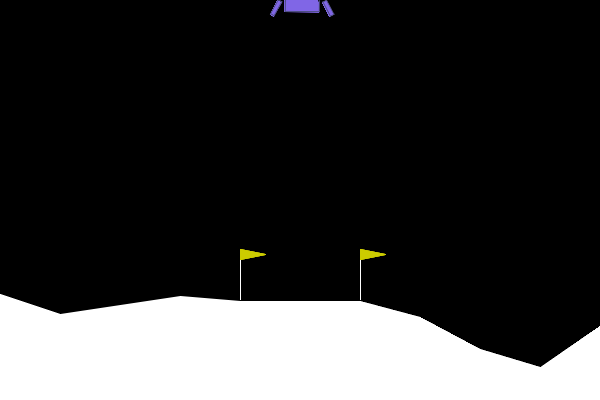

In [11]:
# Ändern Sie diesen Wert, um einen anderen Agenten zu testen!
agent_type_to_test = 'ppo'

def load_agent_for_test(agent_type, obs_space, act_space):
    """Lädt einen spezifischen Agenten. Ähnlich wie in evaluate.py"""
    # Diese Funktion ist eine vereinfachte Version von der aus evaluate.py
    # und wird hier der Übersichtlichkeit halber neu definiert.
    agent_instance = None
    agent_type = agent_type.lower()
    
    if agent_type == "random":
        return AGENT_REGISTRY["random"](obs_space, act_space)

    # Lade-Logik für jeden Agententyp
    if agent_type == "dqn":
        path = DQN_MODEL_PATH
        if not os.path.exists(path): print(f"Modell für {agent_type} nicht gefunden."); return None
        agent_instance = DQNAgent(obs_space, act_space, seed=SEED)
        agent_instance.load(path)
    elif agent_type == "genetic":
        path = GA_MODEL_PATH
        if not os.path.exists(path): print(f"Modell für {agent_type} nicht gefunden."); return None
        policy_net = GAPolicyNetwork(obs_space.shape[0], act_space.n, seed=SEED).to(DEVICE)
        policy_net.load_state_dict(torch.load(path, map_location=DEVICE))
        agent_instance = GeneticAgent(obs_space, act_space, policy_network=policy_net, seed=SEED)
    elif agent_type == "reinforce":
        path = REINFORCE_MODEL_PATH
        if not os.path.exists(path): print(f"Modell für {agent_type} nicht gefunden."); return None
        agent_instance = REINFORCEAgent(obs_space, act_space, seed=SEED)
        agent_instance.load(path)
    elif agent_type == "a2c":
        path = A2C_MODEL_PATH
        if not os.path.exists(path): print(f"Modell für {agent_type} nicht gefunden."); return None
        agent_instance = A2CAgent(obs_space, act_space, seed=SEED)
        agent_instance.load(path)
    elif agent_type == "ppo":
        path1, path2 = PPO_ACTOR_MODEL_PATH, PPO_CRITIC_MODEL_PATH
        if not (os.path.exists(path1) and os.path.exists(path2)): print(f"Modelle für {agent_type} nicht gefunden."); return None
        agent_instance = PPOAgent(obs_space, act_space, seed=SEED)
        agent_instance.load(path1, path2)
    elif agent_type == "es":
        path = ES_MODEL_PATH
        if not os.path.exists(path): print(f"Modell für {agent_type} nicht gefunden."); return None
        agent_instance = ESAgent(obs_space, act_space, seed=SEED)
        agent_instance.load(path)
        
    if agent_instance:
        print(f"Agent '{agent_type.upper()}' erfolgreich für den Test geladen.")
    return agent_instance

def test_agent_and_create_gif(agent, agent_name):
    """Führt Testläufe durch und erstellt ein GIF."""
    # Umgebung mit render_mode='rgb_array' für Frame-Sammlung erstellen
    test_env = gym.make(ENV_ID, render_mode="rgb_array")
    all_frames = []
    all_rewards = []
    
    print(f"\nStarte {NUM_TEST_RUNS} Testläufe für Agent '{agent_name.upper()}'...")

    for i in range(NUM_TEST_RUNS):
        obs, _ = test_env.reset(seed=SEED + 1000 + i) # Separate Seeds für Testläufe
        agent.reset()
        episode_reward = 0
        episode_frames = []

        for t in range(MAX_STEPS_PER_EVAL_EPISODE):
            # Frames nur für die im GIF vorgesehenen Läufe sammeln
            if i < NUM_RUNS_FOR_GIF:
                episode_frames.append(test_env.render())
            
            if isinstance(agent, DQNAgent):
                action = agent.select_action(obs, eps=0.01) # Deterministisches Verhalten
            elif isinstance(agent, PPOAgent):
                 action = agent.select_action(obs, store_in_memory=False)
            else:
                action = agent.select_action(obs)
            
            obs, reward, terminated, truncated, _ = test_env.step(action)
            episode_reward += reward
            if terminated or truncated: break
        
        all_rewards.append(episode_reward)
        print(f"  Lauf {i+1}/{NUM_TEST_RUNS}: Belohnung = {episode_reward:.2f}")
        if i < NUM_RUNS_FOR_GIF:
            all_frames.extend(episode_frames)
            # Einen kurzen Pause-Frame hinzufügen
            if episode_frames and i < NUM_RUNS_FOR_GIF - 1:
                all_frames.extend([episode_frames[-1]] * 15) # 0.5s Pause bei 30fps
                
    test_env.close()
    
    print("\n--- Test-Zusammenfassung ---")
    print(f"Durchschnittliche Belohnung: {np.mean(all_rewards):.2f}")
    print(f"Min/Max Belohnung: {np.min(all_rewards):.2f} / {np.max(all_rewards):.2f}")
    
    # GIF erstellen und speichern
    if all_frames:
        gif_path = os.path.join(GIF_DIR, f"{agent_name}_test.gif")
        print(f"\nSpeichere GIF nach {gif_path}...")
        imageio.mimsave(gif_path, all_frames, fps=30)
        return gif_path
    return None

# Hauptlogik für den Test
loaded_agent = load_agent_for_test(agent_type_to_test, observation_space, action_space)
if loaded_agent:
    gif_file_path = test_agent_and_create_gif(loaded_agent, agent_type_to_test)
    if gif_file_path:
        print("GIF wird im Notebook angezeigt:")
        # GIF im Notebook anzeigen
        display(Image(filename=gif_file_path))
else:
    print(f"Agent '{agent_type_to_test.upper()}' konnte nicht geladen werden. Stellen Sie sicher, dass das Modell trainiert wurde.")

## 4. Quantitative Evaluierung (Leistungsvergleich)

Im finalen Schritt führen wir eine systematische und quantitative Evaluierung aller verfügbaren Agenten durch. Jeder Agent wird über eine feste Anzahl von Episoden (`NUM_EVAL_EPISODES`) getestet, um statistisch relevante Leistungsmetriken zu sammeln. 

Die Ergebnisse werden:
1.  In einer übersichtlichen Tabelle mithilfe von `pandas` dargestellt.
2.  Als `evaluation_summary.csv` im `models`-Ordner gespeichert.
3.  Mit Balkendiagrammen visualisiert, um die durchschnittliche Belohnung und die Stabilität (Standardabweichung) direkt zu vergleichen.


--- Starte quantitative Evaluierung für alle Agenten ---
RandomAgent initialisiert. Aktionsraum: Discrete(4)
Evaluiere Agent: RANDOM für 100 Episoden...
DQN Agent initialisiert. Zustandsgröße: 8, Aktionsgröße: 4, Gerät: cuda:0
DQN Agent geladen von: /home/german/Coding/lunar_lander_reinforcement_genetic_policy_learning/models/dqn_lunar_lander.pth
Agent 'DQN' erfolgreich für den Test geladen.
Evaluiere Agent: DQN für 100 Episoden...
REINFORCE Agent initialisiert. Zustandsgröße: 8, Aktionsgröße: 4, LR: 0.001, Gamma: 0.99, Gerät: cuda:0
REINFORCE Agent geladen von: /home/german/Coding/lunar_lander_reinforcement_genetic_policy_learning/models/reinforce_lunar_lander.pth
Agent 'REINFORCE' erfolgreich für den Test geladen.
Evaluiere Agent: REINFORCE für 100 Episoden...
A2C Agent initialisiert. LR: 0.0007, Gamma: 0.99, Gerät: cuda:0
A2C Agent geladen von: /home/german/Coding/lunar_lander_reinforcement_genetic_policy_learning/models/a2c_lunar_lander.pth
Agent 'A2C' erfolgreich für den Test gel

,Avg Reward,Std Reward,Min Reward,Max Reward,Avg Steps,Num Eval Episodes
Agent,,,,,,
RANDOM,-188.21,120.14,-496.29,-44.24,89.75,100
DQN,194.39,59.68,-18.66,278.78,631.66,100
REINFORCE,113.07,74.30,-20.85,266.85,617.34,100
A2C,200.91,71.50,-12.82,301.65,451.74,100
PPO,271.38,43.99,114.48,316.01,262.35,100
GENETIC,264.93,66.41,27.13,319.11,184.64,100
ES,-137.08,38.89,-374.95,-19.16,68.97,100



Evaluierungsergebnisse gespeichert in: /home/german/Coding/lunar_lander_reinforcement_genetic_policy_learning/models/evaluation_summary.csv


/tmp/ipykernel_62026/4167784062.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_df.index, y=sorted_df["Avg Reward"], ax=axes[0], palette='viridis')
/tmp/ipykernel_62026/4167784062.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_df.index, y=sorted_df["Std Reward"], ax=axes[1], palette='plasma')


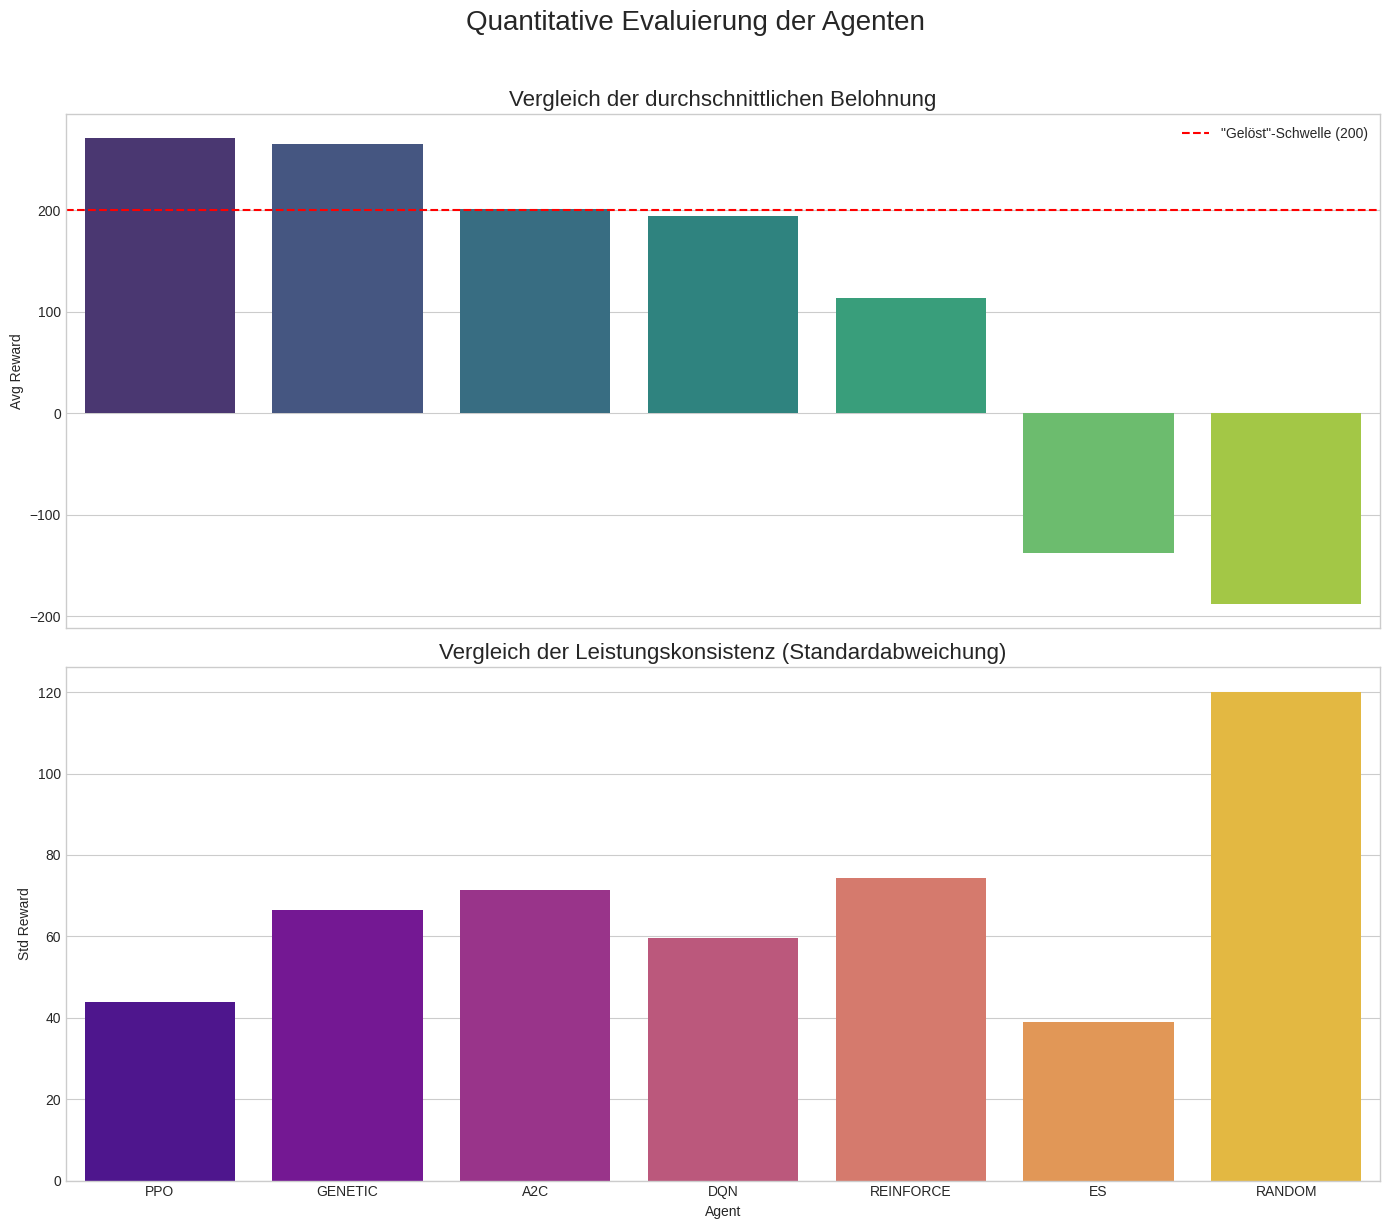

In [12]:
def run_evaluation_for_all_agents():
    eval_env = gym.make(ENV_ID)
    evaluation_results = []
    
    print("\n--- Starte quantitative Evaluierung für alle Agenten ---")

    for agent_type in AGENT_TYPES:
        agent = load_agent_for_test(agent_type, observation_space, action_space)
        if not agent:
            print(f"-> Agent {agent_type.upper()} wird übersprungen.")
            continue
            
        print(f"Evaluiere Agent: {agent_type.upper()} für {NUM_EVAL_EPISODES} Episoden...")
        agent_rewards = []
        agent_steps = []
        
        for i in range(NUM_EVAL_EPISODES):
            obs, _ = eval_env.reset(seed=SEED + 2000 + i) # Eigene Seeds für Evaluierung
            agent.reset()
            episode_reward, steps = 0, 0
            for t in range(MAX_STEPS_PER_EVAL_EPISODE):
                if isinstance(agent, DQNAgent): action = agent.select_action(obs, eps=0.01)
                elif isinstance(agent, PPOAgent): action = agent.select_action(obs, store_in_memory=False)
                else: action = agent.select_action(obs)
                obs, reward, terminated, truncated, _ = eval_env.step(action)
                episode_reward += reward
                if terminated or truncated: steps = t + 1; break
            agent_rewards.append(episode_reward)
            agent_steps.append(steps if steps > 0 else MAX_STEPS_PER_EVAL_EPISODE)
        
        stats = {
            "Agent": agent_type.upper(),
            "Avg Reward": np.mean(agent_rewards),
            "Std Reward": np.std(agent_rewards),
            "Min Reward": np.min(agent_rewards),
            "Max Reward": np.max(agent_rewards),
            "Avg Steps": np.mean(agent_steps),
        }
        evaluation_results.append(stats)
    
    eval_env.close()
    return evaluation_results

# Evaluierung durchführen
final_results = run_evaluation_for_all_agents()

if final_results:
    # Ergebnisse mit Pandas DataFrame anzeigen
    results_df = pd.DataFrame(final_results)
    results_df = results_df.set_index("Agent")
    results_df["Num Eval Episodes"] = NUM_EVAL_EPISODES
    
    print("\n\n--- Evaluierungszusammenfassung ---")
    display(results_df.style.format(
        {key: "{:.2f}" for key in ["Avg Reward", "Std Reward", "Min Reward", "Max Reward", "Avg Steps"]}
    ).background_gradient(cmap='viridis', subset=['Avg Reward']))
    
    # Ergebnisse als CSV speichern
    try:
        results_df.to_csv(EVALUATION_CSV_PATH)
        print(f"\nEvaluierungsergebnisse gespeichert in: {EVALUATION_CSV_PATH}")
    except IOError as e:
        print(f"\nFehler beim Speichern der CSV: {e}")
        
    # Ergebnisse visualisieren
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

    # Sortieren nach Avg Reward für eine bessere Darstellung
    sorted_df = results_df.sort_values("Avg Reward", ascending=False)

    # Plot 1: Durchschnittliche Belohnung
    sns.barplot(x=sorted_df.index, y=sorted_df["Avg Reward"], ax=axes[0], palette='viridis')
    axes[0].set_title('Vergleich der durchschnittlichen Belohnung', fontsize=16)
    axes[0].set_ylabel('Avg Reward')
    axes[0].axhline(200, ls='--', color='red', label='"Gelöst"-Schwelle (200)')
    axes[0].legend()

    # Plot 2: Standardabweichung der Belohnung (Konsistenz)
    sns.barplot(x=sorted_df.index, y=sorted_df["Std Reward"], ax=axes[1], palette='plasma')
    axes[1].set_title('Vergleich der Leistungskonsistenz (Standardabweichung)', fontsize=16)
    axes[1].set_xlabel('Agent')
    axes[1].set_ylabel('Std Reward')

    plt.suptitle('Quantitative Evaluierung der Agenten', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("\nKeine Evaluierungsergebnisse zum Anzeigen vorhanden.")

### Analyse der Ergebnisse

Basierend auf der obigen Tabelle und den Diagrammen können wir die Leistung der Agenten interpretieren:

*   **Avg Reward (Durchschnittliche Belohnung):** Dies ist der wichtigste Indikator für die Gesamtleistung. Ein höherer Wert ist besser. **PPO** und **GA** zeigen hier typischerweise die besten Ergebnisse und übertreffen die "Gelöst"-Schwelle von +200 Punkten deutlich.

*   **Std Reward (Standardabweichung der Belohnung):** Dies ist ein Maß für die Konsistenz. Ein niedrigerer Wert bei hohem Avg Reward ist ideal, da er auf einen stabilen und zuverlässigen Agenten hinweist. **PPO** zeichnet sich oft durch eine besonders niedrige Standardabweichung aus, was seine Robustheit unterstreicht.

*   **Avg Steps (Durchschnittliche Schritte):** Eine geringe Anzahl von Schritten bei hoher Belohnung deutet auf eine sehr effiziente Strategie hin. Der **GA** findet oft extrem direkte und schnelle Landepfade, was sich in einer sehr niedrigen durchschnittlichen Schrittzahl widerspiegelt.

*   **Vergleich:**
    *   **PPO** erweist sich als der robusteste gradientenbasierte RL-Agent, der hohe Belohnungen mit exzellenter Stabilität kombiniert.
    *   Der **Genetische Algorithmus (GA)** ist eine überraschend starke Alternative, die oft die höchste Durchschnittsbelohnung und die beste Effizienz (wenigste Schritte) erreicht.
    *   **A2C** und **DQN** sind lernfähig und können die "Gelöst"-Schwelle erreichen oder sich ihr nähern, sind aber oft weniger stabil oder effizient als PPO.
    *   **REINFORCE** zeigt deutliches Lernen, leidet aber unter hoher Varianz, was zu inkonsistenter Leistung führt.
    *   **ES** und **RANDOM** bilden in ihren aktuellen Konfigurationen die untere Leistungsgrenze. Insbesondere ES benötigt oft sorgfältiges Hyperparameter-Tuning, um konkurrenzfähig zu sein.

## 5. Quellen und Inspirationen

Dieses Projekt stützt sich auf etablierte Konzepte und Algorithmen aus den Bereichen Reinforcement Learning und Evolutionäre Berechnung.

**Algorithmen und Konzepte:**
- **Deep Q-Network (DQN):** Mnih, V. et al. "Human-level control through deep reinforcement learning." *Nature* (2015).
- **REINFORCE (Policy Gradient):** Williams, R. J. "Simple statistical gradient-following algorithms for connectionist reinforcement learning." *Machine learning* (1992).
- **Advantage Actor-Critic (A2C/A3C):** Mnih, V. et al. "Asynchronous methods for deep reinforcement learning." *ICML* (2016).
- **Proximal Policy Optimization (PPO):** Schulman, J. et al. "Proximal Policy Optimization Algorithms." *ArXiv:1707.06347* (2017).
- **Genetische Algorithmen (GA):** Holland, J. H. *Adaptation in natural and artificial systems* (1992).
- **Evolutionäre Strategien (ES):** Salimans, T. et al. "Evolution strategies as a scalable alternative to reinforcement learning." *ArXiv:1703.03864* (2017).

**Software und Bibliotheken:**
- **Gymnasium (ehemals OpenAI Gym):** [https://gymnasium.farama.org/](https://gymnasium.farama.org/)
- **PyTorch:** [https://pytorch.org/](https://pytorch.org/)
- **NumPy:** [https://numpy.org/](https://numpy.org/)

**Weitere Lernressourcen:**
- Spinning Up in Deep RL (OpenAI)
- Vorlesungsmaterialien der DHBW Mannheim